In [1]:
using Distributed
procs_to_use = 5
if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end
;

In [2]:
@everywhere using QuantumStates, OpticalBlochEquations, DifferentialEquations, UnitsToValue, StructArrays, StaticArrays, Parameters

@everywhere import Distributions: Normal, Geometric, Exponential
@everywhere using ProgressMeter, Plots
;

In [3]:
@everywhere include("helper_functions.jl")
@everywhere include("define_molecular_structure.jl")
@everywhere include("define_sim_params.jl")
@everywhere include("define_prob.jl")
@everywhere include("compute_size_temperature.jl")
;

      From worker 5:	(2.28545530795343, 1.142727653976715)


(2.28545530795343, 1.142727653976715)

      From worker 4:	(2.28545530795343, 1.142727653976715)
      From worker 3:	(2.28545530795343, 1.142727653976715)
      From worker 2:	(2.28545530795343, 1.142727653976715)


### "Actual With Diffusion"

In [4]:
n_trajectories1 = 50
n_trajectories2 = 50
# n_times = 100
n_times = 10
# n_trajectories_diffusion = 10000 # # of particles ran for the diffusion.
# diffusion_t_end = 20e-6 # first 10us: reach equilibrium.
# diffusion_τ_total = 20e-6 # and then averaging through 10us evolution.

n_trajectories_diffusion = 50000 # # of particles ran for the diffusion.
diffusion_t_end = 0e-6 # first 10us: reach equilibrium.
diffusion_τ_total = 6e-6 # and then averaging through 10us evolution.
# n_trajectories_diffusion = 500 # # of particles ran for the diffusion.
# diffusion_t_end = 5e-6 # first 10us: reach equilibrium.
# diffusion_τ_total = 1e-3 # and then averaging through 10us evolution.
# n_trajectories_diffusion = 5000 # # of particles ran for the diffusion.
# diffusion_t_end = 10e-6 # first 10us: reach equilibrium.
# diffusion_τ_total = 10e-6 # and then averaging through 10us evolution.
;

In [5]:
(sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
    compute_trajectories_with_diffusion(
    prob, prob_func!, prob, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
) # this is really slow, but this is rigorous.
# (sols_no_diffusion, sols_with_diffusion, diffusion, diffusion_error, diffusion_over_time) = 
#     compute_trajectories_with_diffusion(
#     prob, prob_func!, prob_diffusion, prob_func_diffusion!, n_trajectories1, n_trajectories2, n_trajectories_diffusion, n_times, diffusion_t_end, diffusion_τ_total
# )
;

4

Progress: 100%|█████████████████████████████████████████| Time: 0:08:16
Progress: 100%|█████████████████████████████████████████| Time: 0:57:29m:14


4

Progress: 100%|█████████████████████████████████████████| Time: 0:08:06


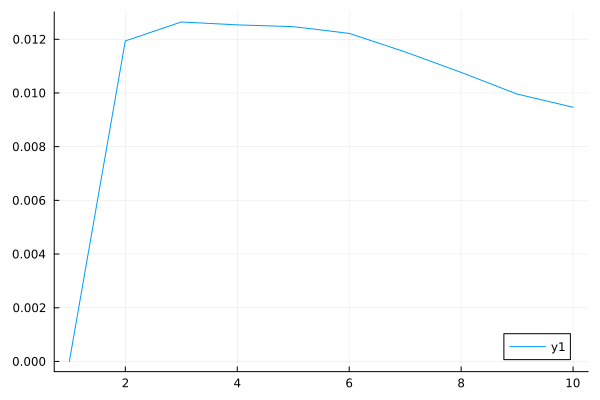

In [6]:
plot(diffusion_over_time)

36.43409963764046

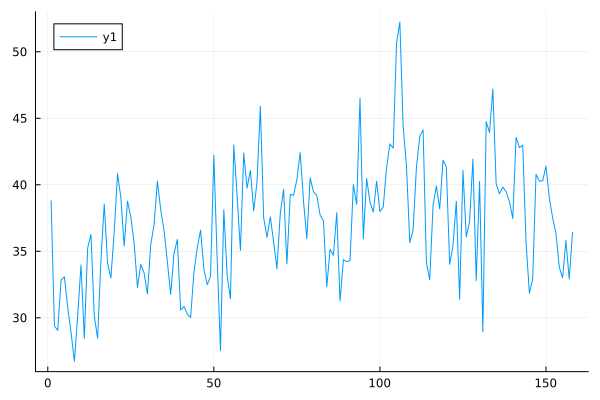

In [7]:
Ts = T_vs_time(sols_no_diffusion)
display(Ts[end] .* 1e6)
plot(Ts .* 1e6)

79.14489359736865

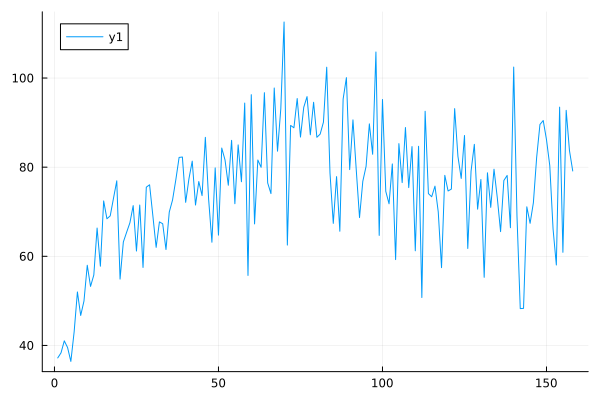

In [8]:
Ts = T_vs_time(sols_with_diffusion)
display(Ts[end] .* 1e6)
plot(Ts .* 1e6)
# 40MHz: 65uK
# 32MHz: 59uK
# 32MHz, twice: 60uK
# 40MHz, twice: 85uK
# 24MHz, twice: 46uK
# 16MHz, twice: 50uK
# 5MHz, twice: (150uK)

# 16MHz at +0.1F2: 48uK
# 16MHz at +1.0F2: 67uK

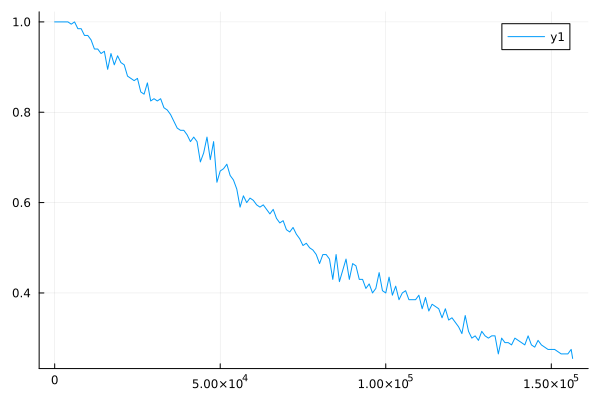

In [9]:
xs_dfshb, ys_dfshb = survival_rate_curve(sols_with_diffusion)
plot(xs_dfshb, ys_dfshb)
# 40MHz: 0.6 at 2ms
# 32MHz: 0.6 at 2ms
# 40MHz, twice: 0.6 at 2ms
# 32MHz, twice: 0.75 at 2ms
# 24MHz, twice: 0.9 at 2ms
# 16MHz, twice: 0.9 at 2ms
# 5MHz, twice: 0.1 at 2ms

# 16MHz at +0.1F2: 0.95 at 2ms
# 16MHz at +1.0F2: 0.72 at 2ms

In [10]:
sols_with_diffusion[10].prob.p.n_scatters / 3e-3 |> display
# should be 200k
# 40MHz: 353k
# 32MHz: 610k
# 40MHz, twice: 166k
# 32MHz, twice: 198k
# 24MHz, twice: 251k
# 16MHz, twice: 333k
# 5MHz, twice: 439k

# 16MHz at +0.1F2: 385k
# 16MHz at +1.0F2: 431k

# n_scatters / log(p)

395666.6666666667

In [11]:
using Serialization
using Printf

# Assuming all variables are defined
filename = @sprintf("results/cooling_sim_d%.2fd%.2fd%.2fb%.2fs%.2fs%.2ft%.2f.jl",
                    detuning,
                    δ1,
                    δ2,
                    beam_radius / 1e-3,
                    s1 / total_sat,
                    s2 / total_sat,
                    Temperature_initial / 1e-6)

serialize(filename, sols_with_diffusion)
